# Introductory applied machine learning (INFR10069)

# Assignment 2: Linear regression

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

Fill out this notebook, save it, and **submit it electronically as described below.**

On a DICE environment, open the terminal, navigate to the location of this notebook, and submit this notebook file using the following command:

`submit iaml cw1 05_Assignment_2.ipynb`

What actually happens in the background is that your file is placed in a folder available to markers. If you submit a file with the same name into the same location, **it will *overwrite* your previous submission**. You can check the status of your submissions with the `show_submissions` command.

**Distance Learners:** To copy your work up to DICE (such that you can use the `submit` command) you can use `scp` or `rsync` (you may need to install these yourself). You can copy files up using `student.ssh.inf.ed.ac.uk`, then ssh in to submit, e.g. (in a unix terminal):
```
filename=05_Assignment_2.ipynb
local_scp_filepath=~/git/iaml2017/${filename}
UUN=s0816700
server_address=student.ssh.inf.ed.ac.uk
scp -r ${local_scp_filepath} ${UUN}@${server_address}:${filename}
# rsync -rl ${local_scp_filepath} ${UUN}@${server_address}:${filename}
ssh ${UUN}@${server_address}
ssh student.login
submit iaml cw1 05_Assignment_2.ipynb
```

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

**Resubmission:** If you submit your file again, the previous submission is **overwritten**. We will mark the version that is in the submission folder at the deadline.

## Important Instructions

1. You *MUST* have your environment set up as in the [README](https://github.com/JamesOwers/iaml2017) and you *must activate this environment before running this notebook*:
```
source activate iaml
cd iaml_2017
jupyter notebook
# Navigate to this file
```

1. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

1. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

1. **IMPORTANT:** Keep your answers brief and concise. Most written questions can be answered with 2-3 lines of explanation.

## Imports

Execute the cell below to import all packages you will be using in the rest of the assignemnt.

In [1]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
%matplotlib inline

## Description of the dataset
This assignment is based on the automobile pricing dataset. Our goal will be to predict the price of automobiles based on various attributes. This data set consists of three types of entities: 

1. The specification of an automobile in terms of various characteristics 

1. Assigned insurance risk rating 
   * this rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuaries call this process ”symboling”. A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe. 

1. Normalized losses in use as compared to other cars
  * the third factor is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year (avg_loss/car/year). 


To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We removed any instances that had one or more missing values and randomized the data set. The resulting representation is much more compact and can be used directly to perform our experiments.


## 1. Simple Linear Regression [50%]
We will begin by studying a simple Linear Regression model. Such a model will consider the relationship between a dependent (response) variable and only one independent (explanatory) variable. When applying machine learning in practice it can be prudent to start out simple in order to get a feeling for the dataset and for any potential difficulties that might warrant a more sophisticated model. In this Section we will consider one independent variable (i.e. feature) `engine-power` against the dependent variable (i.e. target) `price`.

### ========== Question 1.1 --- [1 mark] ==========
Load the dataset `train_auto_numeric.csv` into a pandas DataFrame called `auto_numeric`. Display the number of data points and attributes in the dataset.

In [341]:
data_path = os.path.join(os.getcwd(), 'datasets', 'train_auto_numeric.csv')
auto_numeric = pd.read_csv(data_path, delimiter = ',')
print('Number of data points: {}, number of attributes: {}'.format(auto_numeric.shape[0], auto_numeric.shape[1]))

Number of data points: 159, number of attributes: 16


### ========== Question 1.2 --- [1 mark] ==========
Display the first 8 instances of the dataset.

In [342]:
auto_numeric.head(8)

,normalized-losses,wheel-base,length,width,height,engine-size,bore,stroke,compression-ratio,engine-power,peak-rpm,city-mpg,highway-mpg,mean-effective-pressure,torque,price
0,164.0,99.8,176.6,66.2,54.3,8.85,3.19,3.40,10.0,102000.0,5500.0,24.0,30.0,40.52,57.68,13950.0
1,110.0,99.4,162.4,66.4,54.3,15.18,3.19,3.40,8.0,115000.0,5500.0,18.0,22.0,47.39,59.59,17450.0
2,158.0,105.8,192.7,71.4,51.6,15.18,3.94,2.80,8.5,70000.0,4400.0,28.0,30.0,0.85,3344.79,17710.0
3,106.0,86.6,158.7,67.7,55.9,13.74,3.13,3.50,7.8,140000.0,5600.0,32.0,20.0,44.74,68.97,23875.0
4,192.0,101.2,176.8,64.8,54.3,8.67,3.50,2.80,8.8,101000.0,5800.0,23.0,29.0,44.78,53.48,16430.0
5,194.0,110.0,190.9,71.4,58.7,8.67,3.78,3.90,22.5,101000.0,6000.0,47.0,53.0,1.80,1330.28,16925.0
6,188.0,101.2,176.8,64.8,54.3,26.58,3.31,3.19,9.0,121000.0,4250.0,21.0,28.0,7.19,377.06,20970.0
7,150.0,101.2,176.8,64.8,56.1,26.58,3.03,3.19,8.0,134000.0,4400.0,28.0,37.0,57.37,48.20,21105.0


### ========== Question 1.3 --- [1 mark] ==========
Display the summary statistics for the dataset.

In [343]:
auto_numeric.describe()

,normalized-losses,wheel-base,length,width,height,engine-size,bore,stroke,compression-ratio,engine-power,peak-rpm,city-mpg,highway-mpg,mean-effective-pressure,torque,price
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,121.955975,98.559748,171.698113,65.729560,53.925157,14.056352,3.294528,3.219874,10.446855,98528.301887,5072.012579,27.113208,32.327044,46.180503,200.055031,11684.723270
std,39.434186,5.803361,12.656791,2.292021,2.410446,17.143568,0.296959,0.381833,4.414796,34123.715967,549.988239,7.848229,8.231998,28.780966,513.289289,6744.910579
min,65.000000,86.600000,141.100000,60.300000,49.400000,3.390000,2.540000,2.070000,7.000000,48000.000000,4150.000000,15.000000,18.000000,0.490000,19.400000,5118.000000
25%,93.000000,94.500000,163.400000,64.000000,52.000000,6.960000,3.050000,3.070000,8.600000,69000.000000,4800.000000,22.000000,26.500000,21.775000,34.140000,7372.000000
50%,110.000000,97.000000,171.700000,65.400000,54.100000,9.030000,3.270000,3.270000,9.000000,92000.000000,5100.000000,26.000000,32.000000,49.800000,55.900000,9233.000000
75%,145.000000,101.200000,177.800000,66.500000,55.600000,14.885000,3.580000,3.410000,9.400000,116000.000000,5450.000000,31.000000,37.000000,68.495000,119.990000,14719.500000
max,256.000000,115.600000,202.600000,71.700000,59.800000,174.160000,3.940000,4.170000,23.000000,200000.000000,6600.000000,49.000000,54.000000,99.850000,3912.870000,42056.000000


### ========== Question 1.4 --- [2 marks] ==========
Produce a scatter plot of `price` against `engine-power`. Label axes appropriately and include a title in your plot.

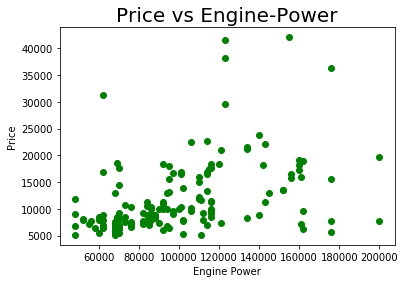

In [344]:
price = auto_numeric['price'].values
power = auto_numeric['engine-power'].values
plt.scatter(power, price, color='g')
plt.xlabel('Engine Power')
plt.ylabel('Price')
plt.title("Price vs Engine-Power", size=20)
plt.show()

### ========== Question 1.5 --- [2 marks] ==========
Do you think that engine-power alone is sufficient for predicting the price? Can you make any other observations on the data from the above plot? Please explain your answer in 2-3 sentences. 

From the scatter plot we can see that there seems to be a correlation between price and engine power. However, the correlation isn't very strong and there seems to be a few outliers that could potentially scew the data and cause large errors. 

### ========== Question 1.6 --- [2 marks] ==========
Visualise the distribution of the car prices. Choose a sensible value for the number of bins in the histogram. Again, label axes appropriately and include a title in your plot.

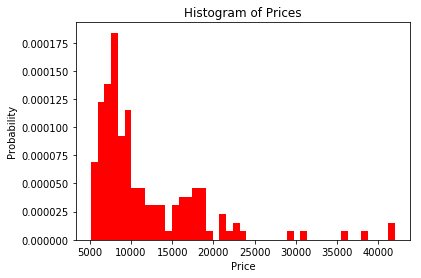

In [345]:
plt.hist(price, 45, normed=1, facecolor='r')
plt.xlabel('Price')
plt.ylabel('Probability')
plt.title('Histogram of Prices')
plt.show()

### ========== Question 1.7 --- [2 marks] ==========
How could you preprocess the data to improve the performance of linear regression? Don’t do it at this stage, but instead in one sentence explain why you would do what you suggested.

Linear regression is sensitive to outliers so trying to remove them beforehand would help attain a better model

### ========== Question 1.8 --- [1 mark] ==========
Now we want to build a simple linear regression model. First we need to define our input and target variables. Store the values of the attribute `engine-power` in a vector `X` and the values of our target variable `price` in a vector `y`.

In [346]:
X = auto_numeric['engine-power'].values
y = auto_numeric['price'].values

### ========== Question 1.9 --- [1 mark] ==========
For technical reasons, we need to convert `X` into a 2D array, otherwise we will receive an error when trying to use it for building models. Perform this transformation and confirm that the shape of the resulting array is (`n`,1) where `n` is the number of instances in the dataset. 

In [347]:
X = X[:,np.newaxis]
X.shape

(159, 1)

### ========== Question 1.10 --- [1 mark] ==========
Now we want to use Hold-out validation to split the dataset into training and testing subsets. Use 80% of the data for training and the remaining 20% for testing. Store your data into matrices `X_train`, `X_test`, `y_train`, `y_test`.

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state=0)

### ========== Question 1.11 --- [2 marks] ==========
By using Scikit-learn's [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) fit a model to the training data. When initialising the model, set the `normalize` parameter to `True` and use default settings for the other parameters.

In [349]:
from sklearn.linear_model import LinearRegression
lrm = LinearRegression(normalize=True)
lrm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

### ========== Question 1.12 --- [2 marks] ==========
By looking into the attributes of your model, write down an equation for predicting the price of a car given the engine-power.

In [350]:
print('PRICE = ({})*(ENGINE-POWER)'.format(lrm.coef_[0]))

PRICE = (0.0898838874387)*(ENGINE-POWER)


### ========== Question 1.13 --- [3 marks] ==========
What happens to the price as one more unit of engine-power is added? By examining the magnitude of the regression coefficient is it possible to tell whether or not engine-power is an important influential variable on price? Explain your answer in 1-2 sentences.

More engine-power results in a higher price. Examining just the coefficient alone doesn't guve us an indication of whether it is a important variable a better way to work this out would be using the correlation coefficient.

### ========== Question 1.14 --- [2 marks] ==========
Produce a scatter plot similar to the one in Question 1.4 but use training data only this time. Add the regression line to the plot and show the predictions on the training set by using a different marker. Label axes appropriately and add a title to the graph. 

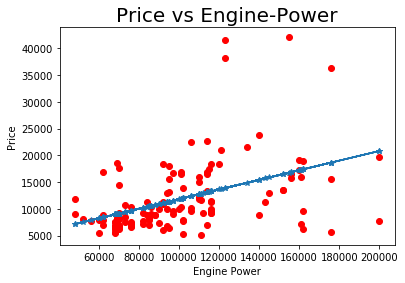

In [351]:
plt.scatter(X_train, y_train, color='r')
plt.xlabel('Engine Power')
plt.ylabel('Price')
plt.title("Price vs Engine-Power", size=20)
plt.plot(X_train, lrm.predict(X_train), marker = '*')
plt.show()

### ========== Question 1.15 --- [2 marks] ==========
So far we have used Hold-out validation. Can you think of a disadvantage of using this method, especially when dealing with small datasets?

When using hold-out validation on a small dataset, the set you train on is very small because it is just a subset of the already small dataset. This can easily lead to the model overfitting the data. This is especially problematic for Linear Regression where outliers easily skew the data when they are a large percentage of the data.

### ========== Question 1.16 --- [1 mark] ==========
Now we want to use k-fold cross-validation to evaluate the performance of the regression model. Famliriase yourself with the sklearn method [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) and make sure you understand the differences between Hold-out and K-fold cross-validation. By using Scikit-learn's [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class construct a 5-fold cross-validation object. Set the `shuffle` parameter to `True` and `random_state` to `0`. Use the object to print the training and validation indices for the `auto_numeric` dataset (hint: see the `split` method).

In [352]:
kf = KFold(n_splits=5, shuffle = True, random_state = 0)
for train_index, test_index in kf.split(auto_numeric):
    print("Training Indices:", train_index, "Testing Indices:", test_index)

Training Indices: [  0   1   2   3   4   5   6   9  10  11  12  13  14  15  16  17  18  20
  21  22  23  25  27  28  29  30  31  32  34  35  36  38  39  41  42  43
  46  47  48  49  50  51  52  53  55  57  58  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  84  87  88  89  91  92
  93  94  96  97  98  99 100 101 102 103 104 105 106 107 108 109 111 112
 113 114 115 116 117 118 121 122 123 124 125 127 129 130 132 133 135 136
 137 138 139 140 141 143 145 146 147 149 150 151 152 153 154 155 156 157
 158] Testing Indices: [  7   8  19  24  26  33  37  40  44  45  54  56  59  60  61  62  63  83
  85  86  90  95 110 119 120 126 128 131 134 142 144 148]
Training Indices: [  0   1   3   4   5   6   7   8   9  11  12  13  14  15  17  19  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  37  38  39  40  41  42
  44  45  46  47  48  49  50  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  67  68  69  70  72  75  76  77  78  79  81  82  83  84  85
  86  8

### ========== Question 1.17 --- [3 marks] ==========
By making use of the iterator you constructed in the previous question, loop through the 5 folds and display the mean value of the `price` variable for the training instances in each fold.

In [353]:
for train_index, test_index in kf.split(auto_numeric):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(y_train.mean())

11853.2677165
11635.976378
11689.8740157
11709.8267717
11535.84375


### ========== Question 1.18 --- [3 marks] ==========
Now initialise a new `LinearRegression` model and fit it by making use of the cross-validation iterator, the `X` and `y` arrays defined above and the [`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) function. Display the shape of your prediction and confirm it has the same dimensionality as your `y` vector.

In [354]:
lrm2 = LinearRegression(normalize=True)
y_pred = cross_val_predict(lrm2, X, y, cv = kf)
print('Prediction Shape: {} Y-vector shape: {}'.format(y_pred.shape, y.shape))

Prediction Shape: (159,) Y-vector shape: (159,)


### ========== Question 1.19 --- [2 marks] ==========
Report the Coefficient of Determination (R^2), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) and Correlation Coefficient (CC) from the simple linear regression model you build in Question 1.18. *Hint: RMSE is the square root of the Mean Squared Error (MSE). For CC you might find numpy's [`corrcoef`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html) function useful.* 

In [355]:
from math import sqrt
from numpy import corrcoef
print('Coefficient of Determination: {}'.format(r2_score(y, y_pred)))
print('Root Mean Squared Error: {}'.format(sqrt(mean_squared_error(y, y_pred))))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y, y_pred)))
print('Correlation Coefficient: {}'.format(corrcoef(y, y_pred)[0,1]))

Coefficient of Determination: 0.173005270976
Root Mean Squared Error: 6114.45211862
Mean Absolute Error: 3987.95779619
Correlation Coefficient: 0.417122199043


### ========== Question 1.20 --- [4 marks] ==========
What do the above metrics intend to measure? Relate the values of CC, MAE and RMSE to the observations you made in Question 1.5. Explain your answer in 1-2 short paragraphs.

The Correlation coefficient measures how strongly the two sets of data relate, Mean Absolute Error and Root Mean Squared Eroor are two metrics to measure the error of the predictions against the actual values. As expected, the model does alright using engine-power as an attribute. 

However, the correlation between the predicted and actual values isn't very strong which relates back to the engine-power in 1.5 not having a strong correlation with the price. Furthermore, as expected the error metrics are large because of the outliers scewing the training and hence the predictions.

### ========== Question 1.21 --- [3 marks] ==========
Show a histogram of the residuals of the linear regression model (i.e. true - predicted values). Label axes appropriately and add a title to your plot. Does the distribution of residuals look like what you expected?

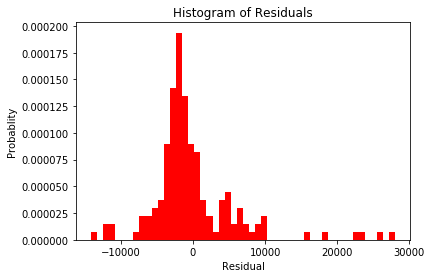

In [356]:
plt.hist((y - y_pred), 50, normed=1, facecolor='r')
plt.xlabel('Residual')
plt.ylabel('Probablity')
plt.title('Histogram of Residuals')
plt.show()

Yes, because on the whole the errors are very slight and the majorty of predictions are close to the actual values. The large residuals with very low probablity correspond to the predicted values not being close to potential outliers.

### ========== Question 1.22 --- [2 marks] ==========
Load the new dataset `train_auto_base.csv` into a pandas DataFrame `auto_base`. Again by using the `engine-power` attribute as predictor and `price` as target variable build a LinearRegression model on this dataset. Report the R^2, RMSE, MAE and CC metrics for this model by making use of the K-fold CV iterator constructed in Question 1.16.

In [378]:
data_path2 = os.path.join(os.getcwd(), 'datasets', 'train_auto_base.csv')
auto_base = pd.read_csv(data_path2, delimiter = ',')
Xb = auto_base['engine-power'].values
Xb = Xb[:,np.newaxis]
yb = auto_base['price'].values
lrm3 = LinearRegression(normalize=True)
yb_pred = cross_val_predict(lrm3, Xb, yb, cv = kf)
print('Coefficient of Determination: {}'.format(r2_score(yb, yb_pred)))
print('Root Mean Squared Error: {}'.format(sqrt(mean_squared_error(yb, yb_pred))))
print('Mean Absolute Error: {}'.format(mean_absolute_error(yb, yb_pred)))
print('Correlation Coefficient: {}'.format(corrcoef(yb, yb_pred)[0,1]))

Coefficient of Determination: -0.00213595381121
Root Mean Squared Error: 6730.84360395
Mean Absolute Error: 4901.86096203
Correlation Coefficient: -0.0619144160589


### ========== Question 1.23 --- [2 marks] ==========
Show a scatter plot of predicted vs. true prices and another one of predicted price vs. engine-power. Use a single plot with two subplots. Label axes appropriately.

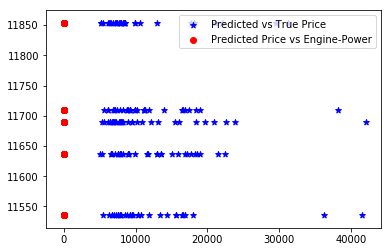

In [358]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(y, yb_pred, c='b', marker="*", label='Predicted vs True Price')
ax1.scatter(Xb, yb_pred, c='r', marker="o", label='Predicted Price vs Engine-Power')
plt.legend(loc='upper right');
plt.show()

### ========== Question 1.24 --- [3 marks] ==========
What is the simplest baseline model for the purposes of regression? Relate your answer to the regression model you have just built as part of this question. Can the predictions of this model be justified given the procedure you followed to train it?

The baseline would be to assume that the price and engine-power are directly correlated (ie. y=X). 

### ========== Question 1.25 --- [2 marks] ==========
Why do you think this model performs so poorly? (*Hint: Justify your answer by displaying some statistics about the `auto_base` dataset.*)

In [359]:
auto_base.describe()

,engine-power,price
count,159.0,159.000000
mean,1.0,11684.723270
std,0.0,6744.910579
min,1.0,5118.000000
25%,1.0,7372.000000
50%,1.0,9233.000000
75%,1.0,14719.500000
max,1.0,42056.000000


From the statistics above, we see that there is no variance in the engine power for this dataset at all while the price still varies a lot. This causes the model to perform badly because there is no correlation between the two values.

## 2. Multivariate Linear Regression [50%]
In this Section we will fit a Multivariate Linear Regression model (LinearRegression) to the dataset. In contrast to Part 1, we will now train a model with multiple explanatory variables and ascertain how they affect our ability to predict the retail price of a car. One of our foremost concerns will be to determine exactly which attributes to include in the model and which may be left out.

### ========== Question 2.1 --- [10 marks] ==========
Use the original dataset (`auto_numeric`) and a visualisation tool of your choice to examine whether or not any of the other attributes are particularly good at predicting the price. Can you find any? Do any attributes appear useless at predicting the price? Do any attributes exhibit significant correlations? As you answer these questions, list two attributes for each question but do not modify the dataset at this stage. Of the attributes you listed, which ones could you safely remove? Explain in 4-5 sentences. *Hint: you might find seaborn's [`pairplot`](https://seaborn.github.io/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) function useful for this question.*

In [ ]:
g = sns.pairplot(data=auto_numeric, , vars = ['normalized-losses', 'peak-mpg', 'highway-mpg', 'torque', 'price', 'engine-power', 'engine-size', 'compression-ratio'])

The torque and compression-ratio attributes seemingly show no correlation with the price and would not be good for predictions and so would be worth removing. On the other hand, higway-mpg and peak-mpg are strongly correlated and so removing one would not affect the result too much. Normalized-losses seems to be a good predictor for the price

### ========== Question 2.2 --- [3 marks] ==========
We will now make a first attempt at building a Multivariate Linear Regression model using all numeric attributes. Initialise a `LinearRegression` model and predict the output by using 5-fold cross-validation and the `cross_val_predict` function.

In [ ]:
mvlrm = LinearRegression(normalize=True)
X_all = auto_numeric.drop(["price"], axis=1)
y_all_pred = cross_val_predict(mvlrm, X_all, y, cv = kf)

### ========== Question 2.3 --- [2 marks] ==========
Display the Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) and Correlation Coefficient (CC).

In [365]:
print('Root Mean Squared Error: {}'.format(sqrt(mean_squared_error(y, y_all_pred))))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y, y_all_pred)))
print('Correlation Coefficient: {}'.format(corrcoef(y, y_all_pred)[0,1]))

Root Mean Squared Error: 4819.80464283
Mean Absolute Error: 3050.34459963
Correlation Coefficient: 0.742560270537


### ========== Question 2.4 --- [2 marks] ==========
 Comment on each metric display above in comparison to what you have obtained for the Simple Linear Regression model in Question 1.19.

Compared to the model in 1.19, all the metrics have improved. The mean errors are much smaller and the correlation of the predicted values with the actual price is musch stronger. This shows that the multi-variate model performed much better than the one which just used engine-power as an attribute

### ========== Question 2.5 --- [2 marks] ==========
Examine the histogram for the `engine-size` attribute. Choose a sensible value for the number of bins in the histogram. Label axes appropriately and include a title in your plot.

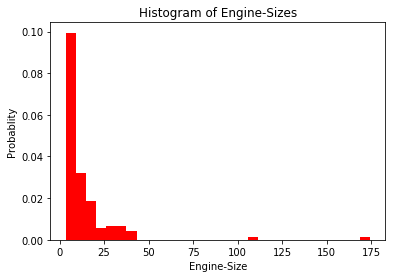

In [366]:
plt.hist(auto_numeric['engine-size'], 30, normed=1, facecolor='r')
plt.xlabel('Engine-Size')
plt.ylabel('Probablity')
plt.title('Histogram of Engine-Sizes')
plt.show()

### ========== Question 2.6 --- [2 marks] ==========
Is the distribution expected to cause a problem for regression? Explain your answer in 2-3 sentences.

Yes there are outliers which will completely scew the data because of Linear Regression's sensitivity to them.

### ========== Question 2.7 --- [3 marks] ==========
Transform this attribute using an appropriate simple technique from the lectures. Plot the histogram of the transformed attribute.

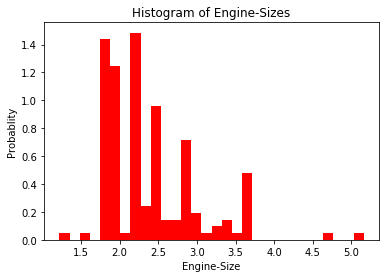

In [367]:
auto_numeric['engine-size'] = np.log(auto_numeric['engine-size'])
plt.hist(auto_numeric['engine-size'], 30, normed=1, facecolor='r')
plt.xlabel('Engine-Size')
plt.ylabel('Probablity')
plt.title('Histogram of Engine-Sizes')
plt.show()

### ========== Question 2.8 --- [3 marks] ==========
Now re-build a Linear Regression model on the transformed dataset and report the R^2, RMSE, MAE and CC metrics.

In [368]:
mvlrm = LinearRegression(normalize=True)
X_all = auto_numeric.drop(["price"], axis=1)
y_all_pred = cross_val_predict(mvlrm, X_all, y, cv = kf)
print('Coefficient of Determination: {}'.format(r2_score(y, y_all_pred)))
print('Root Mean Squared Error: {}'.format(sqrt(mean_squared_error(y, y_all_pred))))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y, y_all_pred)))
print('Correlation Coefficient: {}'.format(corrcoef(y, y_all_pred)[0,1]))

Coefficient of Determination: 0.689612268029
Root Mean Squared Error: 3745.91959756
Mean Absolute Error: 2668.36429567
Correlation Coefficient: 0.831675321658


### ========== Question 2.9 --- [3 marks] ==========
How has the performance of your model changed? Explain your answer in 1-2 sentences.

The performance has improved. The transformed engine-size attribute has caused less error and more correlation between the predicted values and the actual values. This is because the data is no longer scewed by the outliers present in  engine-size.

### ========== Question 2.10 --- [2 marks] ==========
So far we have performed regression with numeric attributes. We will now attempt to integrate nominal (categorical) attributes into our regression model. 
Load the dataset `train_auto_full.csv` into a pandas DataFrame called `auto_full`. Display the number of samples and attributes in the dataset. Also, display the first 20 instances of the dataset. *Hint: Execute the cell below to change the default for `max_columns` display option in pandas.*

In [369]:
pd.set_option('max_columns', 30)

In [370]:
data_path3 = os.path.join(os.getcwd(), 'datasets', 'train_auto_full.csv')
auto_full = pd.read_csv(data_path3, delimiter = ',')
print('Number of Samples: {}, Number of Attributes: {}'.format(auto_full.shape[0], auto_full.shape[1]))
auto_full.head(20)

Number of Samples: 159, Number of Attributes: 27


,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,engine-power,peak-rpm,city-mpg,highway-mpg,symboling,mean-effective-pressure,torque,price
0,164.0,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,ohc,4,8.85,mpfi,3.19,3.40,10.00,102000.0,5500.0,24.0,30.0,2,40.52,57.68,13950.0
1,110.0,audi,gas,std,4,sedan,4wd,front,99.4,162.4,66.4,54.3,ohc,5,15.18,mpfi,3.19,3.40,8.00,115000.0,5500.0,18.0,22.0,2,47.39,59.59,17450.0
2,158.0,audi,gas,std,4,sedan,fwd,front,105.8,192.7,71.4,51.6,ohc,5,15.18,mpfi,3.94,2.80,8.50,70000.0,4400.0,28.0,30.0,1,0.85,3344.79,17710.0
3,106.0,audi,gas,turbo,4,sedan,fwd,front,86.6,158.7,67.7,55.9,ohc,5,13.74,mpfi,3.13,3.50,7.80,140000.0,5600.0,32.0,20.0,1,44.74,68.97,23875.0
4,192.0,bmw,gas,std,2,sedan,rwd,front,101.2,176.8,64.8,54.3,ohc,4,8.67,mpfi,3.50,2.80,8.80,101000.0,5800.0,23.0,29.0,2,44.78,53.48,16430.0
5,194.0,bmw,gas,std,4,sedan,rwd,front,110.0,190.9,71.4,58.7,ohc,4,8.67,mpfi,3.78,3.90,22.50,101000.0,6000.0,47.0,53.0,0,1.80,1330.28,16925.0
6,188.0,bmw,gas,std,2,sedan,rwd,front,101.2,176.8,64.8,54.3,ohc,6,26.58,mpfi,3.31,3.19,9.00,121000.0,4250.0,21.0,28.0,0,7.19,377.06,20970.0
7,150.0,bmw,gas,std,4,sedan,rwd,front,101.2,176.8,64.8,56.1,ohc,6,26.58,mpfi,3.03,3.19,8.00,134000.0,4400.0,28.0,37.0,0,57.37,48.20,21105.0
8,121.0,chevrolet,gas,std,2,hatchback,fwd,front,88.4,141.1,60.3,53.2,l,3,3.39,2bbl,3.03,3.03,9.50,48000.0,5300.0,47.0,53.0,2,59.33,25.08,5151.0
9,98.0,chevrolet,gas,std,2,hatchback,fwd,front,104.3,155.9,68.3,52.0,ohc,4,6.05,2bbl,3.31,3.47,7.80,70000.0,5000.0,34.0,34.0,1,51.55,36.35,6295.0


### ========== Question 2.11 --- [3 marks] ==========
This dataset contains a mixture of numeric and nominal attributes. Name the variables that you think are categorical. Why can we not use the nominal attributes in their current form for the purposes of regression? 

Body-style, num-of-doors, make, fuel-type, aspiration, engine-location and drive-wheels are all categorical. We can't use the data in it's current form because regression relies on numeric attributes. The categorical data mentioned earlier can only be compared for equality. Assigning a higher value to 'dodge' over 'honda' for example, would be incorrect

### ========== Question 2.12 --- [5 marks] ==========
Now we want to convert the categorical variables by using [One-Hot-Encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder). Familiarise yourself with the class. One limitation with this module is that it can deal only with categorical attributes in integer format (remember that in our example we have attributes in string format). 

Copy the `auto_full` dataframe into a new dataframe `auto_full_edit` and transform the categorical variables by using [Label Encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Then transform again the categorical variables by using One-Hot-Encoding. Make sure you don't transform the continuous variables. *Hint: make appropriate use of the `categorical_features` parameter in [`OneHotEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder).*

Store the transformed attributes into a numpy array `X_enc` and display its dimensionality.  


In [371]:
auto_full_edit = auto_full.copy()
le = LabelEncoder()
ohe = OneHotEncoder(categorical_features = [1,2,3,4,5,6,7])
auto_full_edit = auto_full_edit.apply(le.fit_transform)
X_enc = auto_full_edit.drop(["price"], axis=1)
X_enc = ohe.fit_transform(X_enc)

### ========== Question 2.13 --- [2 marks] ==========
By using the transformed data train a multivariate linear regression model and by using 5-fold cross-validation report the R^2, RMSE, MAE and CC metrics.

In [372]:
mvlrm = LinearRegression(normalize=True)
y_full_pred = cross_val_predict(mvlrm, X_enc, y, cv = kf)
print('Coefficient of Determination: {}'.format(r2_score(y, y_full_pred)))
print('Root Mean Squared Error: {}'.format(sqrt(mean_squared_error(y, y_full_pred))))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y, y_full_pred)))
print('Correlation Coefficient: {}'.format(corrcoef(y, y_full_pred)[0,1]))

Coefficient of Determination: 0.844217903004
Root Mean Squared Error: 2653.78020628
Mean Absolute Error: 1678.78746338
Correlation Coefficient: 0.919947390485


### ========== Question 2.14 --- [4 marks] ==========
How does this more complex model perform with respect to your best performing model from either question 2.3 or 2.8? List one advantage and one disadvantage of using the more complex model.

This model performs better than both the previous models seen in all metrics. The use of a more complex model can be advantageous as it performs better. However, it is very possible that the model will now over fit the training data,  given that there are now many attributes.

### ========== Question 2.15 --- [4 marks] ==========
Finally, experiment with tree-based regressors (e.g. [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html), [`RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)) and report 5-fold cross-validation scores for R^2, RMSE, MAE and CC. Has your performance improved? Explain your answer in 1-2 sentences.

In [381]:
dtr = LinearRegression()
y_tree = cross_val_predict(dtr, X_enc, y, cv = kf)
print('Decision Tree Regressor:')
print('Coefficient of Determination: {}'.format(r2_score(y, y_tree)))
print('Root Mean Squared Error: {}'.format(sqrt(mean_squared_error(y, y_tree))))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y, y_tree)))
print('Correlation Coefficient: {}'.format(corrcoef(y, y_tree)[0,1]))
rfr = RandomForestRegressor()
y_forest = cross_val_predict(rfr, X_enc, y, cv = kf)
print('Random Forest Regressor:')
print('Coefficient of Determination: {}'.format(r2_score(y, y_forest)))
print('Root Mean Squared Error: {}'.format(sqrt(mean_squared_error(y, y_forest))))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y, y_forest)))
print('Correlation Coefficient: {}'.format(corrcoef(y, y_forest)[0,1]))

Decision Tree Regressor:
Coefficient of Determination: 0.854020739572
Root Mean Squared Error: 2568.92696405
Mean Absolute Error: 1657.06670917
Correlation Coefficient: 0.925045975724
Random Forest Regressor:
Coefficient of Determination: 0.818094392713
Root Mean Squared Error: 2867.67031659
Mean Absolute Error: 1956.98867925
Correlation Coefficient: 0.906898701998


The performance of the Decision Tree is slighly better than any of the models seen before with its mean errors lower than the last model and correleation a bit better than what was seen with the Multi Variate Linear Regressor. However the Random Forest Regressor actually performs worse than the MVLR. This is probably due to some of the trees in the random forest not performing well and hence affecting the predicted value